In [1]:
import Pkg; Pkg.activate("./")

  Activating project at `~/Documents/Research/MonitoringMetrology/BackAction.jl/notebooks`


In [2]:
using Random, Statistics, Plots, LaTeXStrings, DifferentialEquations, LinearAlgebra, BackAction, Base.Threads, StatsBase

In [3]:
function sample_c2(seed)
    theta = pi*rand()
    phi = 2*pi*rand()
    return [cos(theta*0.5); exp(1im*phi)*sin(theta*0.5)] 
end

sample_c2 (generic function with 1 method)

In [4]:
# Set up the unravelings
seed = 12
Random.seed!(seed)
println("1. Draw a random T")
T = sample_c2(seed) #T_matrix = reshape([-0.32839473+0.66388951*1im;
                    #-0.17785852+0.64789966*1im], 2, 1)# sample_c2(seed)
T = reshape(T/norm(T), 2,1)
println("Sanity check, T is an isometry ") 
println("T^daggerT = 1: $(adjoint(T)*T)", "\tdims=$(size(adjoint(T)*T))")
println("We are using T = ", T, "\n")

println("2. Transform T into T_curvy, the 2x2 matrix")
T_curvy = [real(T[1]) imag(T[1]); real(T[2]) imag(T[2]) ]
println("We are using T_curvy=", T_curvy)

println("3.Polar decomposition")
println("3.1 get the SVD (see https://en.wikipedia.org/wiki/Polar_decomposition#Relation_to_the_SVD)")
F = svd(T_curvy) # Factorization object
println("Sanity check, this do is an SVD factorization:")
println("|T_curvy - F.U * Diagonal(F.S) * F.Vt|_2 =", opnorm(T_curvy - F.U * Diagonal(F.S) * F.Vt),"\n") # Evaluate distance using the Frobenious norm
println("3.2 Define P and O")
P = F.V * Diagonal(F.S) * F.Vt
O = F.U * F.Vt
println("Sanity check, O is orthogonal and P is positive symmetric")
println("|O^T O - I|_2 , |O O^T - I |_2 = ", opnorm(I - O'*O), "\t",opnorm(I - O*O'))
println("|P - P^T|= ",  opnorm(P - P'))
println("Eigenvalues of P: ", eigen(P).values, "\n")

println("4. Obtain T_curvy_dyne")
T_curvy_dyne = O' * T_curvy
println("T_curvy_dyne = ")
println(T_curvy_dyne, "\n")

println("5. Obtain T_dyne")
T_dyne = O' * real.(T) + 1im * O' * imag.(T)
println("Sanity check: T_curvy_dyne has as columns the real/imaginary parts of T_dyne")
println("|T_curvy_dyne[1, :] - real(T_dyne)| = ", norm(T_curvy_dyne[1, :] - real(T_dyne)))
println("|T_curvy_dyne[2, :] - imag(T_dyne)| = ", norm(T_curvy_dyne[2, :] - imag(T_dyne)))
println("T_dyne =")
println(T_dyne)
println("Sanity check: T_curvy_dyne is an isometry")
println("T_dyne^dagger T_dyne = $(adjoint(T)*T)\n" )

println("6. Now define the matrices we will use for the unravelings")
Ta = T 
Tb = T_dyne 
Tc = T_dyne 
println("T_a = ", Ta)
println("T_b = ", Tb)
println("T_c = ", Tc)

Ts = Dict([("a", Ta), ("b", Tb), ("c", Tc)]) # Dictionary with the Ts
println("Sanity check: the the T's are isometries")
for key in keys(Ts)
    println("$key : ", adjoint(Ts[key]) * Ts[key])
end

println("We are using the alphas:")
alpha0 = [2.0 + 0im; 2.0 + 0im] 
alphas = Dict([("a", alpha0), ("b", alpha0), ("c", O' * alpha0)]) # Dictionary with the alphas
for key in keys(Ts)
    println("$key : ", adjoint(alphas[key]))
end


1. Draw a random T
Sanity check, T is an isometry 
T^daggerT = 1: ComplexF64[1.0 + 0.0im;;]	dims=(1, 1)
ComplexF64[0.8761683917948627 + 0.0im; 0.44655879420710654 - 0.18142269024545674im;;]

2. Transform T into T_curvy, the 2x2 matrix
[0.8761683917948627 0.0; 0.44655879420710654 -0.18142269024545674]
3.Polar decomposition
3.1 get the SVD (see https://en.wikipedia.org/wiki/Polar_decomposition#Relation_to_the_SVD)
Sanity check, this do is an SVD factorization:
|T_curvy - F.U * Diagonal(F.S) * F.Vt|_2 =3.517710614720084e-16

3.2 Define P and O
Sanity check, O is orthogonal and P is positive symmetric
|O^T O - I|_2 , |O O^T - I |_2 = 8.950121547012058e-16	8.950121547012058e-16
1.3877787807814457e-17
Eigenvalues of P: [0.16105950740645658, 0.9869446970696937]

4. Obtain T_curvy_dyne
T_curvy_dyne = 
[0.9808697823762669 -0.07057108108309518; -0.07057108108309512 0.1671344220998839]

5. Obtain T_dyne
Sanity check: T_curvy_dyne has as columns the real/imaginary parts of T_dyne
6.938893903907228

In [5]:
# Parameters and time evaluation
ntimes = 75
params = SimulParameters(1/sqrt(2) * [1.0 + 0im;1.0 + 0im], #initial condition
    25.0, #tf
    1, # seed
    1_000, # Number of trajectories
    # You can ignore the rest, they are only used for the Gillipsie method
    25_000, # Number of samples in the finegrid
    4.0, # Multiplier to use in the fine grid
    1e-3 # Tolerance for passing Dark state test
)
t_eval = collect(LinRange(0.0, params.tf, ntimes));
gamma = 0.25
delta = 0.0
omega = 1.0
# Operator definitions
H = 0.5*delta*BackAction.sigma_z + 0.5*omega*BackAction.sigma_x
L = sqrt(gamma)*BackAction.sigma_m

2×2 Matrix{ComplexF64}:
 0.0+0.0im  0.5+0.0im
 0.0+0.0im  0.0+0.0im

In [6]:
# Function for obtaianing a sample of Bloch vectors from a given T
function get_r_sample(T, alpha)
    sys = System(H, [L], T, alpha)
    # Problem definition
    @time begin
    sim = get_sol_jumps(sys, params, extrema(t_eval); reltol=1e-8);
    end
    # observable evaluation 
    r_sample = Array{Float64}(undef, 3, ntimes,params.ntraj)
    sigma = [BackAction.sigma_x, BackAction.sigma_y, BackAction.sigma_z]
    @threads for n in 1:params.ntraj
                 for t in 1:ntimes
                    psi = sim[n](t_eval[t])
                    for k in 1:3
                        r_sample[k, t, n] = real(dot(psi, sigma[k], psi))/dot(psi, psi)
                     end
                 end 
            end 
    return r_sample
end

get_r_sample (generic function with 1 method)

In [7]:
# Analytical solution
function resonance_fluorescene!(du, u, p, t)
    #     -0.5*gamma*(2*nbar+1)*r[1] - delta*r[2]
    # delta*r[1] - 0.5*gamma*(2*nbar+1)*r[2] - omega*r[3];
    # omega*r[2] - gamma*(2*nbar+1)*r[3] - gamma]

    du[1] = - 0.5*gamma*u[1] - delta*u[2]  
    du[2] = + delta*u[1] - 0.5*gamma*u[2]- omega*u[3]  
    du[3] = omega*u[2] - gamma*u[3] - gamma
end
u0 = [1.0, 0.0, 0.0]
prob_analytical = ODEProblem(resonance_fluorescene!, u0, extrema(t_eval))
sol_analytical = solve(prob_analytical);

In [8]:
r_samples = Dict()
for key in keys(Ts)
    r_samples[key] = get_r_sample(Ts[key], alphas[key])
end

  9.178471 seconds (18.19 M allocations: 1.598 GiB, 27.03% gc time, 47.47% compilation time)
  4.358631 seconds (13.25 M allocations: 1.266 GiB, 28.09% gc time)
  4.458961 seconds (13.47 M allocations: 1.285 GiB, 29.29% gc time)


In [9]:
colors = Dict()
colors["a"] = "green"
colors["b"] = "yellow"
colors["c"] = "red"

"red"

In [10]:
lines = [:dash, :dot, :solid]

3-element Vector{Symbol}:
 :dash
 :dot
 :solid

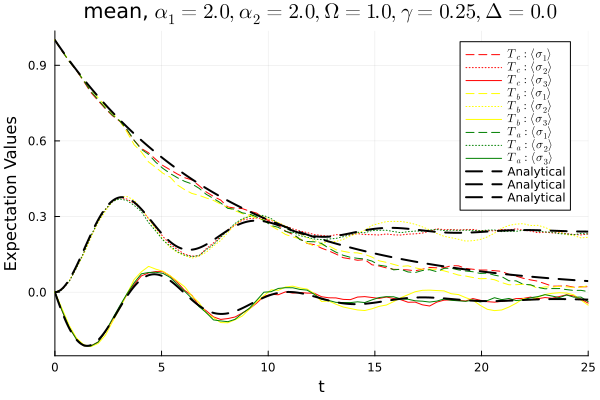

In [24]:
# Now plot the  n-th moment for z
p = plot(title="mean, "*L"\alpha_1=%$(norm(alpha0[1])), \alpha_2=%$(norm(alpha0[2])), \Omega=%$(omega), \gamma=%$(gamma), \Delta=%$(delta)",
     xlabel="t", ylabel="Expectation Values")
for key in keys(Ts)
    for k in 1:3
        data = [mean(r_samples[key][k, t, :]) for t in 1:ntimes ]
        plot!(t_eval, data, label=L"T_%$key:\langle\sigma_%$k\rangle", color=colors[key], line=lines[k]) 
    end
end 
plot!(sol_analytical,   label="Analytical", linewidth=2, line=:dash, color="black")
savefig("Images/mean%$(omega)_$(gamma)_$(delta)_$(alpha0[1])_$(alpha0[2]).png")
p